In [101]:
import os
import pandas as pd
import numpy as np

In [ ]:
pose_threshold = 6 # Euclidian distance for "no significant movement"
subset_threshold = 5
window_size = 24 # Frames for non-minimum suppression (24 per second), 
                # half of actual window size because both sides are checked
round_val = 10
option = "left_arm"

In [184]:
default = ["MidHip-X", "MidHip-Y"]
neck = ["Nose-Neck-RShoulder", "Nose-Neck-LShoulder",]
right_arm = ["Neck-RShoulder-RElbow", "RShoulder-RElbow-RWrist", "RHip-RShoulder-RElbow",]
left_arm = ["Neck-LShoulder-LElbow", "LShoulder-LElbow-LWrist", "LHip-LShoulder-LElbow",]
torso = ["MidHip-RHip-RShoulder", "MidHip-LHip-LShoulder",]
right_leg = ["MidHip-RHip-RKnee", "RHip-RKnee-RAnkle", "RKnee-RAnkle-RBigToe",]
left_leg = ["MidHip-LHip-LKnee", "LHip-LKnee-LAnkle", "LKnee-LAnkle-LBigToe",]
arms = np.append(left_arm, right_arm)
legs = np.append(left_leg, right_leg)
limbs = np.append(arms, legs)
all_parts = np.append(np.append(default, neck), np.append(torso, limbs))

options = {
    "default": default,
    "neck": neck,
    "right_arm": right_arm,
    "left_arm": left_arm,
    "torso": torso,
    "right_leg": right_leg,
    "left_leg": left_leg,
    "arms": arms,
    "legs": legs,
    "limbs": limbs,
    "all": all_parts
}

In [191]:
# Function to calculate Euclidean distance between two points
def histogram_score(p1, p2, df):
    # Include only columns with absolute differences greater than 45
    included_columns = [col for col in df if abs(p1[col] - p2[col]) >= round_val]
    
    # Create modified points with non-included columns set to 0
    # modified_p1 = p1.copy()
    # modified_p2 = p2.copy()
    # for col in df.columns:
    #     if col not in included_columns:
    #         modified_p1[col] = 1
    #         modified_p2[col] = 1
    
    # Calculate the Euclidean distance using modified points
    # distance = np.linalg.norm(modified_p1.values[1:] - modified_p2.values[1:])
    # print(modified_p1)
    # print(modified_p2)
    return len(included_columns) + np.linalg.norm(p1[included_columns].values[1:] - 
                                                  p2[included_columns].values[1:]) / 100 + np.linalg.norm(
                                                      p1.values[1:] - p2.values[1:])  /100000
                                        
def euclidean_of_subset(p1, p2, included_columns):
    modified_p1 = p1.copy()
    modified_p2 = p2.copy()
    for col in included_columns:
        if abs(p1[col] - p2[col]) <= 15:
            modified_p1[col] = 0
            modified_p2[col] = 0
    return np.linalg.norm(modified_p1[included_columns].values[1:] -  modified_p2[included_columns].values[1:]) + np.linalg.norm(p1.values[1:] - p2.values[1:]) / 100                      

# Function to calculate Euclidean distances between consecutive rows
def calculate_distances(df, pose):
    distances = []
    for i in range(0, len(df)):
        distance = histogram_score(df.iloc[i], pose, df)
        distances.append(distance)
    return distances

histogram = []
histogram_null = []
def non_minimum_suppression(df, distances):
    outliers = []
    for i in range(0, len(distances)-1):
        if distances[i] < pose_threshold:
            min_in_window = min(distances[max(0, i-window_size):min(len(distances)-1, i+window_size+1)])

            if distances[i] <= min_in_window:
                # print(min_in_window, distances[i])
                outliers.append(i)
                histogram.append(distances[i])
            else:
                # print(min_in_window, distances[i])
                pass
    if outliers == []:
        histogram_null.append(min(distances[0:-1]))
    return outliers

In [104]:
filepath = "../data/2_angles/Chinese12.csv"
with open(filepath, 'r') as file:
    df = pd.read_csv(file)
print(histogram_score(df.iloc[650], df.iloc[1589], df))
print(df.iloc[[650, 1589]])
# print(df.iloc[1589])

4.78851576223224
      Unnamed: 0  Nose-Neck-RShoulder  Nose-Neck-LShoulder  \
650          650            83.528136           102.397596   
1589        1589            81.498194           104.078761   

      Neck-RShoulder-RElbow  Neck-LShoulder-LElbow  RShoulder-RElbow-RWrist  \
650              136.586865             170.490720               153.090331   
1589             137.768735             174.917929               161.357869   

      LShoulder-LElbow-LWrist  RHip-RShoulder-RElbow  LHip-LShoulder-LElbow  \
650                151.012446             143.663072              76.650170   
1589               165.395785             149.505786              73.662407   

      MidHip-RHip-RShoulder  MidHip-LHip-LShoulder  MidHip-RHip-RKnee  \
650               93.835486              98.394789          92.205483   
1589             103.810057              96.485943          99.910033   

      MidHip-LHip-LKnee  RHip-RKnee-RAnkle  LHip-LKnee-LAnkle  \
650           52.989476         152

In [150]:
def get_poses(filepath, pose, df=0):
    if not filepath == "df":
        with open(filepath, 'r') as file:
            df = pd.read_csv(file)
        # df = (df / round_val).round() * 10
    distances = calculate_distances(df, pose)
    # print(distances)
    outliers = non_minimum_suppression(df, distances)
    df_filtered = df.iloc[outliers]
    return outliers, df_filtered

In [187]:
def calculate_distances_subset(df, pose):
    distances = []
    for i in range(0, len(df)):
        distance = euclidean_of_subset(df.iloc[i], pose, options[option])
        distances.append(distance)
    return distances

histogram = []
histogram_null = []
def non_minimum_suppression_subset(df, distances):
    outliers = []
    for i in range(0, len(distances)-1):
        if distances[i] < subset_threshold:
            min_in_window = min(distances[max(0, i-window_size):min(len(distances)-1, i+window_size+1)])

            if distances[i] <= min_in_window:
                # print(min_in_window, distances[i])
                outliers.append(i)
                histogram.append(distances[i])
            else:
                # print(min_in_window, distances[i])
                pass
    if outliers == []:
        histogram_null.append(min(distances[0:-1]))
    return outliers
    
def get_poses_subset(filepath, pose, df=0):
    if not filepath == "df":
        with open(filepath, 'r') as file:
            df = pd.read_csv(file)
        # df = (df / round_val).round() * 10
    distances = calculate_distances_subset(df, pose)
    # print(distances)
    outliers = non_minimum_suppression_subset(df, distances)
    df_filtered = df.iloc[outliers]
    return outliers, df_filtered

In [194]:
in_dir = "../data/2_angles"
out_dir = "../data/5_similar_poses"
# target = ['single_leg_balance_pro_dir.csv', [3, 86, 243, 437]]
# target = ['Chinese12.csv', [955, 1035, 1066, 1115, 1215, 1372, 1391, 1487, 1589, 1661, 1719, 1833]]
target = ['NeuralGlideMedianBias_train.csv', [38, 141]] #, 205, 268, 352, 435, 576]]
histogram = []
histogram_null = []

with open(os.path.join(in_dir, target[0]), 'r') as file:
    target_df = pd.read_csv(file)
# target_df = (target_df / round_val).round() * 10

print("[")
print(f"\t\"{target[0]}\",")
for target_frame in target[1]:
    print("\t[")
    print(f"\t\t{target_frame},")
    for filename in os.listdir(in_dir):
        if filename != target[0]:
            filepath = os.path.join(in_dir, filename)
            frames, poses = get_poses_subset(filepath, target_df.iloc[target_frame])
        # else:
        #     frames, poses = get_poses("df", target_df.iloc[target_frame], target_df.iloc[:899])
            output_path = os.path.join(out_dir, filename)
            print(f"\t\t{[filename, frames]},")
    # poses.to_csv(output_path)
    print("\t],")
print("]")

print(histogram)
print(histogram_null)

[
	"NeuralGlideMedianBias_train.csv",
	[
		38,
		['Chinese12.csv', [66, 133, 237, 506, 584, 661, 738, 817, 865, 1019, 1070, 1148, 1378, 1442, 1540, 1602, 1667, 1759, 1800]],
		['Chinese14.csv', [171, 222, 304, 363, 393, 449, 500, 573, 608, 667, 734, 918, 966, 999, 1038, 1083]],
		['Chinese15.csv', [143, 187, 294, 347, 379, 431, 472, 617, 693, 760, 818, 1114, 1145, 1199, 1264, 1302, 1372, 1449, 1529, 1618, 1662, 1692, 1723, 1760, 1856]],
		['Chinese16.csv', []],
		['Chinese17.csv', [105, 149, 182, 240, 300, 357, 432, 684, 733, 780, 812, 852, 881]],
		['Chinese19.csv', [160, 221, 322, 388, 454, 523, 556, 584, 670, 715, 790, 826, 872, 948, 1001, 1038, 1144, 1188, 1244, 1327, 1368, 1424, 1529, 1634, 1666, 1718, 1749, 1819, 1850, 1892, 1966, 2115, 2246, 2317, 2356, 2416, 2441]],
		['Chinese20.csv', [45, 130, 185, 395, 580, 647, 754, 786, 977, 1126, 1210, 1314, 1361, 1442, 1486, 1716, 1799, 1843, 2011]],
		['Indian1.csv', [14, 171, 251, 361, 702, 875, 1190, 1220, 1370, 1640, 1767, 1794, 1879

7.5, 24, 30
[
	"single_leg_balance_pro_dir.csv",
	[
		3,
		['Chinese12.csv', []],
		['Chinese14.csv', [21]],
		['Chinese15.csv', []],
		['Chinese16.csv', []],
		['Chinese17.csv', []],
		['Chinese19.csv', []],
		['Chinese20.csv', []],
		['Indian1.csv', []],
		['Indian2.csv', []],
	],
	[
		86,
		['Chinese12.csv', []],
		['Chinese14.csv', []],
		['Chinese15.csv', []],
		['Chinese16.csv', []],
		['Chinese17.csv', []],
		['Chinese19.csv', []],
		['Chinese20.csv', []],
		['Indian1.csv', []],
		['Indian2.csv', []],
	],
	[
		243,
		['Chinese12.csv', []],
		['Chinese14.csv', [219, 268]],
		['Chinese15.csv', [254]],
		['Chinese16.csv', []],
		['Chinese17.csv', []],
		['Chinese19.csv', []],
		['Chinese20.csv', []],
		['Indian1.csv', [1057]],
		['Indian2.csv', [270, 495]],
	],
	[
		437,
		['Chinese12.csv', []],
		['Chinese14.csv', []],
		['Chinese15.csv', []],
		['Chinese16.csv', []],
		['Chinese17.csv', [431]],
		['Chinese19.csv', []],
		['Chinese20.csv', []],
		['Indian1.csv', [1059]],
		['Indian2.csv', []],
	],
]
[5.773422618345988, 5.8815835321055685, 5.9637899037190145, 5.71725357923793, 7.405704217851194, 5.189290454340276, 7.122581595984391, 6.001085108547932, 7.422010930016791]
[11.34532996101498, 11.357342213631972, 15.437551489707728, 10.789324841081312, 12.711886309566632, 13.095044074283845, 7.682624824331303, 8.474038504484126, 10.920435537303137, 11.83604686455851, 12.023115099228013, 16.1972504617903, 11.487158017199336, 13.657738203443188, 14.216634212810211, 8.617319784457765, 8.17814920357956, 10.924511287072422, 14.020467674157993, 10.398610308525322, 12.521865005988731, 12.680283187368417, 11.012532836704361, 10.609256230814545, 10.910569086117372, 15.060336983345271, 12.595183312387894, 12.717361930702221, 8.135493263556427]


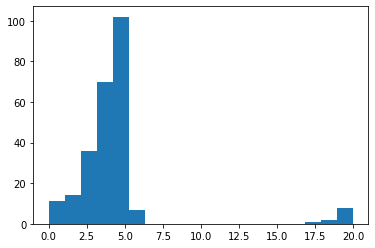

In [195]:
import matplotlib.pyplot as plt
plt.hist(histogram, bins=19)
plt.show()